# Predicting EDSS Scores from EVO Monitor Metrics

## Background

[Multiple sclerosis](https://www.nationalmssociety.org/What-is-MS/Definition-of-MS) (MS) is an unpredictable immune-mediated disease that damages the central nervous system, disrupting the communication of information within the body and leading to physical and mental symptoms . A measure of the level of disability for a person with MS is the [Kurtzke Expanded Disability Status](https://www.va.gov/MS/Professionals/Diagnosis/Kurtzke_Expanded_Disability_Status_Scale.asp) (EDSS), which is a widely used measure to quantify the level of functioning. Currently, EDSS is measured through a physical test; however, digitalization and automatic prediction of a patient's EDSS has the potential to increase accessibility and ease of determining an EDSS.

EVO Monitor is a platform that measures attention, executive function, and speed of information processing for clinical populations, where players engage in tasks similar to a video game. It has already been confirmed to act as an assessment for cognitive ability in children with and without cognitive disabilities; [a recent observational study](https://www.jmir.org/2021/1/e24356) suggests that it is a viable approach to measure cognitive performance in patients with MS. 

This project looks at the usage of machine learning to predict a patient's EDSS scores given their metrics. 

## Relevant Modules

### [pandas](https://pandas.pydata.org/docs/)
_pandas_ is an open-source Python module that allows for dataset structuring, manipulation, and analysis. This module is used to read data from an external file into an object that can be processed by Python. 

### [NumPy](https://numpy.org/doc/)
_NumPy_ is a Python module that supports arrays and matrices, and allows for manipulation of these objects. This module will be used to store data, weights, and biases. 

### [scikit-learn](https://scikit-learn.org/stable/)
_scikit-learn_ is a Python module that contains data analysis tools, including machine learning models. It is built on top of the _NumPy_, _SciPy_, and _matplotlib_ libraries. This project will be using _scikit-learn_'s MLP model and linear regression model to learn predictions. 

In [2]:
# import necessary modules

import pandas as pd
import numpy as np 
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

## The Dataset

The input dataset for this project is a numpy array of size (99, 39). It consists of data from 99 multiple sclerosis patients with varying levels of disability (and therefore varying EDSS scores). Each patient has 39 metrics generated from using the EVO Monitor platform, which will be used to predict the EDSS score.  

The output dataset is a vector of size (99, 1). It contains the EDSS score for the 99 multiple sclerosis patients mentioned previously. 

The data is divided into an 90-10 train and test split. 

In [3]:
b = pd.read_excel('[DATA]') # import data
b = b[:-24] # remove nonused data (healthy controls)
b = b.drop(index=[57,100])  # remove blank lines
target_column = ['EDSS']    # y parameter
predictors = ['tar_avg_m0m1_artHit_mean', 'tar_phase_s0_artHit_mean',       # x parameters; EVO game data
       'tar_cost_s0mAvg_artHit_mean', 'tar_avg_m0m1_artHit_norm',
       'tar_phase_s0_artHit_norm', 'tar_cost_s0mAvg_artHit_norm',
       'tar_avg_m0m1_artHit_sd', 'tar_phase_s0_artHit_sd',
       'tar_cost_s0mAvg_artHit_sd', 'tar_avg_m0m1_rspAll_pc',
       'tar_phase_s0_rspAll_pc', 'tar_cost_s0mAvg_rspAll_pc',
       'tar_avg_m0m1_rspFa_rate', 'tar_phase_s0_rspFa_rate',
       'tar_cost_s0mAvg_rspFa_rate', 'tar_avg_m0m1_rspHit_rate',
       'tar_phase_s0_rspHit_rate', 'tar_cost_s0mAvg_rspHit_rate',
       'tar_avg_m0m1_rtHit_mean', 'tar_phase_s0_rtHit_mean',
       'tar_cost_s0mAvg_rtHit_mean', 'tar_avg_m0m1_rtHit_norm',
       'tar_phase_s0_rtHit_norm', 'tar_cost_s0mAvg_rtHit_norm',
       'tar_avg_m0m1_rtHit_sd', 'tar_phase_s0_rtHit_sd',
       'tar_cost_s0mAvg_rtHit_sd', 'nav_avg_m0m1_thresh',
       'tar_avg_m0m1_thresh', 'tn_avg_m0m1_thresh', 'trade_avg_m0m1_thresh',
       'nav_phase_s0_thresh', 'tar_phase_s0_thresh', 'tn_phase_s0_thresh',
       'trade_phase_s0_thresh', 'nav_cost_s0mAvg_thresh',
       'tar_cost_s0mAvg_thresh', 'tn_cost_s0mAvg_thresh',
       'trade_cost_s0mAvg_thresh']
X = b[predictors].values                            # assign input data
y = b[target_column].values                         # assign output data

In [4]:
np.random.seed(5) # seed the data split
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape((y.shape[0],)), test_size=0.09) # split data into train and test split
X_train = X_train/X_train.max(axis=0)   # normalize training data 

## MultiLayer Perceptron

A MultiLayer Perceptor (MLP) is a basic neural network architecture, which is beneficial for this problem as it offers simplicity but also the advantages of a complex neural network. It has 3 main parts: 
* the input layer (contains input data) 
* the hidden layers (neuron layers that are densely connected; each layer has a set of neurons that each compute an activation function based on its inputs, weights, and biases) 
* the output layer (a single neuron that computes a ReLU activation function; this is because this project's problem is a regression problem that outputs a nonnegative single value) 

![alt text](https://www.researchgate.net/profile/Mohamed_Zahran6/publication/303875065/figure/fig4/AS:371118507610123@1465492955561/A-hypothetical-example-of-Multilayer-Perceptron-Network.png)
**A visualization of a multilayer perceptron. Image credits:** https://www.researchgate.net/figure/A-hypothetical-example-of-Multilayer-Perceptron-Network_fig4_303875065

The hyperparameters of importance in _scikit-learn_'s MLP model are: 
* the layer sizes (a tuple with the size and structure of the hidden layers)
* the activation function (to be used in the hidden layers)
* the solver (the optimizer that the model uses to "learn")
* the maximum number of iterations (set to a large number, the model automatically stops once convergence is reached)


In [5]:
# set constant hyperparameter variables
MAX_ITERATIONS = 15000 # maximum number of training epochs 


In [6]:
# create MLP model  
mlp = MLPRegressor(max_iter=MAX_ITERATIONS)

# below code from https://datascience.stackexchange.com/a/96937; sets output activation as relu 

mlp._old_initialize=mlp._initialize
def _initialize(self, y, layer_units, dtype):
    self._old_initialize(y, layer_units, dtype)
    self.out_activation_="relu"
    
mlp._initialize = _initialize.__get__(mlp)

## GridSearch

GridSearch is a model selection tool by _scikit-learn_ that searches over specified parameter values for a given estimator. This tool will be used to select the best combination of hyperparamaters for the MLP model as per the training set (it also automatically splits the training set into cross-validation sets).


In [7]:
# set hyperparameter values to test using GridSearch

LAYER_SIZES = (8,8,8) # size and structure of the dense hidden layers in the MLP model
ACTIVATION = ['relu', 'tanh', 'logistic', 'identity']   # activation of the hidden layers in the MLP model
SOLVER = ['lbfgs', 'sgd', 'adam']       # solver used to reach convergence

In [8]:
# creates a GridSearch object that will find the "best" model given a set of parameters 
clf = GridSearchCV(mlp, {'hidden_layer_sizes': [(i,i,i) for i in range(8,51)], 
                         'activation':ACTIVATION, 'solver':SOLVER}, scoring='neg_mean_absolute_error')

**NOTE: the following block of code takes a very long time to run.**

In [ ]:
#clf.fit(X_train, y_train)    # train the GridSearch Object

In [ ]:
predict_train = clf.predict(X_train)                # get training prediction error
train_err = mean_absolute_error(y_train, predict_train)
b = predict_train-y_train
x = pd.DataFrame({'actual':y_train, 'predicted':predict_train, 'diff':b})

In [ ]:
X_test = X_test/X_test.max(axis=0)       # normalize validation data
predict_test = clf.predict(X_test)                  # get test prediction error
testerr = mean_absolute_error(y_test, predict_test)
diff = predict_test-y_test
y = pd.DataFrame({'actual':y_test, 'predicted':predict_test, 'diff':diff})

## Example Model Returned by GridSearch

In [4]:
import pickle
example_mod = pickle.load(open('./Display Examples/example_mlp_gridsearch_model.sav', 'rb')) # load saved model

After loading the saved model, the model is used to predict the EDSS score given the data in the training set.

In [5]:
predict_train = example_mod.predict(X_train)                # get training prediction error
train_err = mean_absolute_error(y_train, predict_train) # predict training error 
b = predict_train-y_train # find difference
x = pd.DataFrame({'actual':y_train, 'predicted':predict_train, 'diff':b}) # create table of values
print(f'Training error: {train_err}\n')
x

Training error: 1.1870881143053054



,actual,predicted,diff
0,3.0,3.282919,0.282919
1,2.5,3.688451,1.188451
2,4.5,4.168095,-0.331905
3,6.0,5.656439,-0.343561
4,4.0,3.398285,-0.601715
...,...,...,...
85,0.0,0.491398,0.491398
86,3.0,2.260460,-0.739540
87,3.5,3.178700,-0.321300
88,1.0,3.136521,2.136521


The model can also be used to predict the EDSS score given data in the test set which it has not been exposed to before.

In [6]:
predict_test = example_mod.predict(X_test)                # get test prediction error
test_err = mean_absolute_error(y_test, predict_test)
y = predict_test-y_test
c = pd.DataFrame({'actual':y_test, 'predicted':predict_test, 'diff':y})
print(f'Test error: {test_err}\n')
c

Test error: 61.121471590370284



,actual,predicted,diff
0,3.0,-42.657107,-45.657107
1,4.0,-56.330036,-60.330036
2,0.0,-45.376166,-45.376166
3,3.5,-30.240947,-33.740947
4,7.0,-67.809493,-74.809493
5,4.0,-39.113977,-43.113977
6,6.0,-56.397768,-62.397768
7,4.0,-100.233123,-104.233123
8,5.5,-74.934627,-80.434627


## Linear Regressor

An alternate model that can be used is the linear regression model, which can also be thought of as a single neuron that computes a linear activation. The model can be understood as fitting a trend line to the dataset provided, and using that trend line to predict new values. A linear model predicts continuous values, which makes it useful for this scenario. 

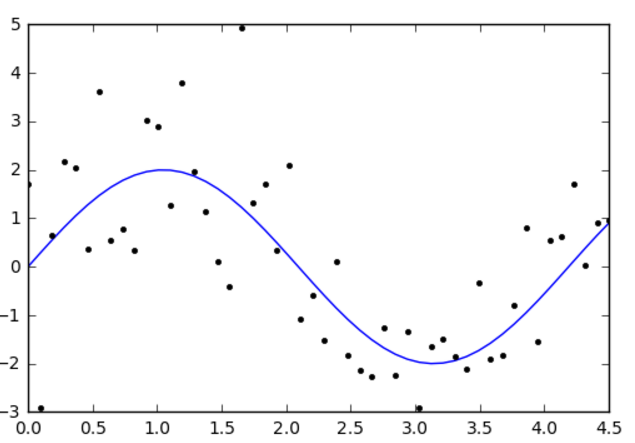

**A visualization of a linear regression model. Image credits:** https://daryan.tistory.com/23

GridSearch will also be used to find the best set of hyperparameters; in this case, the parameters to be searched through is simply alpha (the learning rate of the model).

In [7]:
# import necessary models for linear regression

from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [8]:
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1)),
    ('model', GridSearchCV(SGDRegressor(), {'alpha':[pow(10,x) for x in range(5, -10, -1)]}))
]
lg = Pipeline(steps).fit(X_train, y_train) # create procedure to follow, train model 

In [9]:
predict_train = lg.predict(X_train) # get training predictions
train_err = mean_absolute_error(y_train, predict_train) # predict training error 
b = predict_train-y_train # find difference
x = pd.DataFrame({'actual':y_train, 'predicted':predict_train, 'diff':b}) # create table of values
print(f'Training error: {train_err}\n')
x

Training error: 1.4244020940940623



,actual,predicted,diff
0,3.0,3.805985,0.805985
1,2.5,2.834775,0.334775
2,4.5,4.642287,0.142287
3,6.0,4.174232,-1.825768
4,4.0,3.434729,-0.565271
...,...,...,...
85,0.0,2.650009,2.650009
86,3.0,2.981586,-0.018414
87,3.5,3.105254,-0.394746
88,1.0,3.311667,2.311667


In [10]:
X_test = X_test/X_test.max()       # normalize validation data
predict_test = lg.predict(X_test)                # get test prediction error
test_err = mean_absolute_error(y_test, predict_test)
y = predict_test-y_test
c = pd.DataFrame({'actual':y_test, 'predicted':predict_test, 'diff':y})
print(f'Test error: {test_err}\n')
c

Test error: 1.6256299952365587



,actual,predicted,diff
0,3.0,3.722960,0.722960
1,4.0,3.614358,-0.385642
2,0.0,3.707032,3.707032
3,3.5,3.964267,0.464267
4,7.0,3.499624,-3.500376
5,4.0,3.721457,-0.278543
6,6.0,3.368012,-2.631988
7,4.0,3.224001,-0.775999
8,5.5,3.336138,-2.163862


## Discussion 

### Scoring

The metric used to measure error for both the MLP model and the linear regression model was **mean absolute error**. This metric measures the absolute value difference between two values, and in the context of this project, measures the absolute value difference between the actual EDSS score of a patient and the predicted EDSS score of a patient. 

### MultiLayer Perceptron 

#### High Bias  
This model has a high bias problem. The model performs poorly on both the training and test set, with a mean absolute error of 1. This poses an issue, as the model is considered raw and cannot be used yet. This is most likely due to the lack of data, which limits how well the model can learn. 

#### Negative Outputs
The output neuron has a ReLU activation function, and should output a nonnegative value for predictions. However, the model predicts negative values, especially for the test set. This may be due to the application of biases to the prediction, which can make the value negative. In future projects, possibilities for limiting the model output should be considered. 

### Linear Regression

#### High Bias   
This model has a high bias problem as well, and is likely due to the small training set. 

#### Lack of variance in predictions
This model outputs predictions that are very similar in value, ranging from 2-4 regardless of the actual value. This is likely linked to the high bias problem as well, since the model was not able to capture the relationship between the input data and the output prediction

## Conclusion

Machine learning is a viable option for automating prediction of cognitive ability through measures such as EDSS scores. Reaching this goal would ease the testing process when used with EVO Monitor and other platforms that increase accessibility of clinical tests. This project was unable to satisfactorily train a prediction model due to various limitations, but further data collection and studies would likely be able to achieve better results. 

## Acknowledgements

* Wan-Yu Hsu, Riley Bove
    * Department of Neurology, Weill Institute for Neurosciences, University of California, San Francisco, San Francisco, CA, United States
* EVO Monitor Akili Interactive Labs, Inc.